# Introduction

## Lab2: Train a Convolutional Neural Network (CNN).

In this Lab session we will learn how to train a CNN from scratch for classifying MNIST digits.

In [1]:
# import necessary libraries
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F

### Define LeNet

![network architecture](https://www.researchgate.net/profile/Lucijano-Berus/publication/329891470/figure/fig1/AS:707347647307776@1545656229128/Architecture-of-LeNet-5-a-Convolutional-Neural-Network-for-digits-digits-recognition-An.ppm)

Here we are going to define our first CNN which is **LeNet** in this case. This architecture has been introduced and is detailed in [this article](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). To construct a LeNet we will be using some convolutional layers followed by some fully-connected layers. The convolutional layers can be simply defined using `torch.nn.Conv2d` module of `torch.nn` package. Details can be found [here](https://pytorch.org/docs/stable/nn.html#conv2d). Moreover, we will use pooling operation to reduce the size of convolutional feature maps. For this case we are going to use `torch.nn.functional.max_pool2d`. Details about maxpooling can be found [here](https://pytorch.org/docs/stable/nn.html#max-pool2d)

Differently from our previous Lab, we will use a Rectified Linear Units (ReLU) as activation function with the help of `torch.nn.functional.relu`, replacing `torch.nn.Sigmoid`. Details about ReLU can be found [here](https://pytorch.org/docs/stable/nn.html#id26).

In [32]:
class LeNet(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    # input channel = ?, output channels = ?, kernel size = ?
    # input image size = (?, ?), image output size = (?, ?)
    self.conv1 = torch.nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1,padding=2)

    # input channel = ?, output channels = ?, kernel size = ?
    # input image size = (?, ?), output image size = (?, ?)
    self.conv2 = torch.nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1)

    # input dim = ? ( H x W x C), output dim = ?
    self.lin1 = torch.nn.Linear(in_features=400,out_features=120)

    # input dim = ?, output dim = ?
    self.lin2 = torch.nn.Linear(in_features=120,out_features=84)

    # input dim = ?, output dim = ?
    self.lin3 = torch.nn.Linear(in_features=84,out_features=10)

  def forward(self, x):
   
    x = self.conv1(x)
  
    # Max Pooling with kernel size = ?
    # output size = (?, ?)
    x = F.max_pool2d(x,2)
    
    x = self.conv2(x)
 
    # Max Pooling with kernel size = ?
    # output size = (?, ?)
    x = F.max_pool2d(x,2)
   
    # flatten the feature maps into a long vector
    x = x.view(x.shape[0], -1)
    
    x = self.lin1(x)
    x = F.relu(x)
    
    x = self.lin2(x)
    x = F.relu(x)

    x = self.lin3(x)
    x = F.softmax(x,dim=1)

    return x

In [56]:
net = LeNet()

### Define cost function

In [4]:
def get_cost_function():
  cost_function = torch.nn.BCELoss()
  return cost_function

### Define the optimizer

We will use SGD with learning rate-lr, weight_decay=wd and  momentum=momentum

In [3]:
def get_optimizer(net, lr, wd, momentum):
  optimizer =  torch.optim.SGD(net.parameters(),lr,momentum,weight_decay=wd)
  return optimizer

### Train and test functions

In [52]:
def test(net, data_loader, cost_function, device='cpu'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device).to(torch.float32)
      targets = targets.to(device)

      # Forward pass
      outputs = net(inputs)
      #outputs= torch.argmax(outputs,dim=1).to(torch.float32)
      target_hot = F.one_hot(targets, num_classes=10).to(torch.float32)
      
      
      # Apply the loss
      loss = cost_function(outputs, target_hot)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def train(net,data_loader,optimizer,cost_function, device='cpu'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.


  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device).to(torch.float32)
    targets = targets.to(device)

    # Forward pass
    outputs = net(inputs)
    #outputs= torch.argmax(outputs,dim=1).to(torch.float32)

    target_hot = F.one_hot(targets, num_classes=10).to(torch.float32)

    # Apply the loss
    loss = cost_function(outputs,target_hot)

    # Reset the optimizer
    
    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

### Define the function that fetches a data loader that is then used during iterative training.

We will learn a new thing in this function as how to Normalize the inputs given to the network.

***Why Normalization is needed***?

To have nice and stable training of the network it is recommended to normalize the network inputs between \[-1, 1\].

***How it can be done***?

This can be simply done using `torchvision.transforms.Normalize()` transform. Details can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).

In [8]:
def get_data(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.MNIST('./TP1/MNIST', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.MNIST('./TP1/MNIST', train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

### Wrapping everything up

Finally, we need a main function which initializes everything + the needed hyperparameters and loops over multiple epochs (printing the results).

In [11]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(batch_size=128,
         device='cpu',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50):

  train_loader, val_loader, test_loader = get_data(batch_size)


  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

Lets train!

In [53]:
main()

Before training:
	 Training loss 0.00255, Training accuracy 10.50
	 Validation loss 0.00128, Validation accuracy 10.83
	 Test loss 0.00130, Test accuracy 11.12
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00252, Training accuracy 25.07
	 Validation loss 0.00123, Validation accuracy 40.48
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00173, Training accuracy 63.26
	 Validation loss 0.00037, Validation accuracy 84.44
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00050, Training accuracy 88.92
	 Validation loss 0.00019, Validation accuracy 91.41
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00033, Training accuracy 92.57
	 Validation loss 0.00014, Validation accuracy 93.85
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00026, Training accuracy 94.23
	 Validation loss 0.00012, Validation accuracy 94.79
---------------

Using the proper metric from sklearn, check which character is most frequently confused with which: can you explain why ?



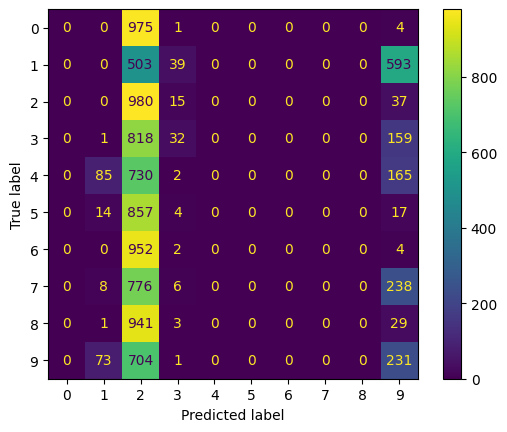

In [55]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
train_loader, val_loader, test_loader = get_data(128)

gt = []
pred = []

for batch_idx, (inputs, targets) in enumerate(test_loader):

    outputs = net(inputs)
    gt.append(targets)
    pred.append(torch.argmax(outputs,dim=1))

pred = torch.cat(pred,dim=0).numpy()
gt = torch.cat(gt,dim=0).numpy()

cm = confusion_matrix(gt,pred)
display = ConfusionMatrixDisplay(cm)
display.plot()

The LeNet5 architecture can also be implemented using the sequential API ([see documentation ](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Reimplement it with this API.

##Experiments


* Implement adaptive early stopping: if the validation loss did not decrease for K consecutive epochs, stop training.
* Change dataset in order to evaluate the LeNet5 network on cifar10 dataset. You can have a look at the pytorch to easily access the cifar10 dataset.
* Try to improve performance with:
   *   data-augmentation
   *   dropout
* Implement the resnet18 architecture using the Resnet18 class from pytorch.



